# Simulations

2024-09-21

This notebook simulates all the portfolios from 2007-03-30 to 2022-09-30

## Equity Simulations

Simulations for only S&P 500 and Eurostoxx 600

In [145]:
import pandas as pd
import numpy as np
import csv
import ujson 
import json
from tqdm.notebook import tqdm
from pandas import Timestamp
from datetime import datetime, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn
import investpy
import pandas_market_calendars as mcal
from tqdm.notebook import tqdm

In [173]:
import pandas_market_calendars as mcal

# convert datetime objects to string objects
def convert_dates(datelist):
    for i in range(len(datelist)):
        datelist[i] = datelist[i].strftime('%Y-%m-%d')
    return [x.strftime('%Y-%m-%d') for x in datelist]
    
# trading calendar
nyse = mcal.get_calendar('NYSE')
lse = mcal.get_calendar('LSE')

# monthly datelist
monthly_dates_spx = convert_dates(nyse.valid_days(start_date='2007-01-01', end_date='2024-04-01').to_series().resample('ME').last())
monthly_dates_euro = convert_dates(lse.valid_days(start_date='2007-01-01', end_date='2024-04-01').to_series().resample('ME').last())

us_bond_dates = [x.strftime('%Y-%m-%d') for x in sorted(list(us_bonds_const.keys()))][29:]
us_bond_dates = us_bond_dates[:95] + ['2015-01-31'] + us_bond_dates[95:]
euro_bond_dates = [x.strftime('%Y-%m-%d') for x in sorted(list(euro_bonds_const.keys()))][9:]
monthly_dates_spx = monthly_dates_spx[2: 2 + len(us_bond_dates)]
monthly_dates_euro = monthly_dates_euro[2: 2 + len(us_bond_dates)]

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\3401082784.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\3401082784.py:6: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\3401082784.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\3401082784.py:6: FutureWarning:

Series.__

In [243]:
portfolio_returns_spx = {}
portfolio_returns_euro = {}

# round values to 3 decimal places
def rd(x):
    return round(x, 3) 
    
def liquidate(portfolios, price, d):
    if len(portfolios['holdings']):
        # sell at last available price
        prices = pd.Series([price[isin][price[isin]['date'] <= d].iloc[-1]['close'] for isin in portfolios['holdings'].index])
        prices.index = portfolios['holdings'].index
        portfolios['account_value'] = sum(prices * portfolios['holdings'])
    # track history
    portfolios['history'].append(portfolios['account_value']) 
    return portfolios
    
# Calculate Portfolio Returns
def portfolioMetrics(history):
    annual_return = (history[-1]/history[0])**(1/(len(history)/12)) - 1
    annual_std = np.array([(history[i] - history[i - 1])/history[i - 1] for i in range(1, len(history))]).std() * np.sqrt(12)
    print(f"Average Return (Per Annum): {rd(((history[-1]/history[0])**(1/len(history)))**12)}")
    print(f"Final Value: {rd(history[-1])}\n")

def simulate(datelist, df, price, name, pfr):
    portfolios = {'account_value': 100000, 'holdings': {}, 'history': []}
    for date in tqdm(datelist):
        portfolios = liquidate(portfolios, price, date)
        if date in df.index.get_level_values(0):
            portfolios['holdings'] = portfolios['account_value'] * (df.loc[date]['market_cap'] * df.loc[date]['Free Float'] / df.loc[date]['close'])/sum(df.loc[date]['market_cap'] * df.loc[date]['Free Float'])  
        else:
            portfolios['holdings'] = pd.Series([])

    pfr[name] = portfolios['history']
    print(f"\n\033[4m{name} Portfolio Metrics\033[0m")
    portfolioMetrics(portfolios['history'])
    
    fig = make_subplots()
    fig.add_trace(go.Scatter(x=datelist, y=portfolios['history'], mode='lines', name='benchmark'))
    fig.update_layout(
        title=f'Portfolio Performance {name}',
        xaxis_title='Date',
        yaxis_title='Portfolio Value',
        legend_title='Portfolios',
        template='plotly_dark', 
        xaxis=dict(tickangle=-45) 
    )
    fig.show()

def analyze(datelist, pfr, t1, t2, t3):
    fig = make_subplots()
    fig.add_trace(go.Scatter(x=datelist, y=pfr[t1], mode='lines', name='benchmark'))
    fig.add_trace(go.Scatter(x=datelist, y=pfr[t2], mode='lines', name='not_esg_all'))
    fig.add_trace(go.Scatter(x=datelist, y=pfr[t3], mode='lines', name='meet_esg'))
    
    fig.update_layout(
        title=f'Portfolio Performance Trend RRI ESG Score Monthly Market Cap Weighted',
        xaxis_title='Date',
        yaxis_title='Portfolio Value',
        legend_title='Portfolios',
        template='plotly_dark', 
        xaxis=dict(tickangle=-45),
        yaxis_type="log"
    )
    fig.show()
    
    metrics = {}
    rf = 0
    
    history = pd.Series(pfr[t1])
    bench = pd.Series([(history.iloc[i]/history.iloc[i - 1] - 1) for i in range(1, len(history))])
    bench = bench.set_axis(datelist[1:])
    bench_rets = (bench + 1).cumprod()
    bench_annual = bench_rets[-1] ** (1/(len(bench_rets)/12)) - 1
    for t in [t1, t2, t3]:
        history = pd.Series(pfr[t])
        ret = pd.Series([(history.iloc[i]/history.iloc[i - 1] - 1) for i in range(1, len(history))])
        ret = ret.set_axis(datelist[1:])
    
        win_rate = len(ret[ret > 0])/len(ret[ret != 0])
        sharpe = ((ret - rf).mean()/ret.std(ddof=1))*np.sqrt(12)
        sortino = ((ret - rf).mean()/(np.sqrt((ret[ret < 0] ** 2).sum() / len(ret))))*np.sqrt(12)
        rets = (ret + 1).cumprod()
        information = (rets[-1] ** (1/(len(rets)/12)) - 1 - bench_annual)/((ret - bench).std() * np.sqrt(12))
        information2 = np.sqrt(12) * (ret -  bench).mean()/(ret - bench).std() 
        mx = rets.cummax()
        dds = rets/mx - 1
        
        metrics[t] = {}
        metrics[t]['Start Date'] = ret.index[0]
        metrics[t]['End Date'] = ret.index[-1]
        metrics[t]['Annual Return'] = rd(rets[-1] ** (1/(len(rets)/12)) - 1)
        metrics[t]['Win Rate (weekly)'] = rd(win_rate*100)
        metrics[t]['Sharpe'] = rd(sharpe)
        metrics[t]['Sortino'] = rd(sortino)
        metrics[t]['Information Ratio'] = rd(information)
        metrics[t]['Max Drawdown'] = rd(min(dds))
    
        print(t)
        print(f'Annual Return: {rd(rets[-1] ** (1/(len(rets)/12)) - 1)}')
        # print(f'STD: {(ret - bench).std()}')
        print(f'Max Drawdown: {rd(min(dds))}')
        print(f'Information Ratio: {rd(information2)}')
        print()

  0%|          | 0/187 [00:00<?, ?it/s]


benchmark/financials/util/above Portfolio Metrics
Average Return (Per Annum): 1.033
Final Value: 165413.161



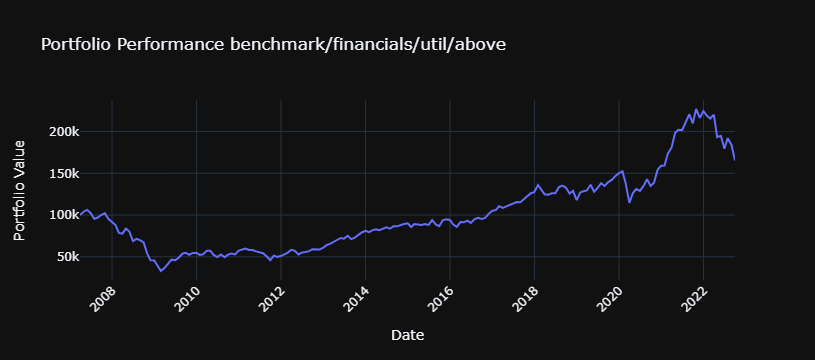

  0%|          | 0/187 [00:00<?, ?it/s]


not_esg/financials/util/above Portfolio Metrics
Average Return (Per Annum): 1.065
Final Value: 266971.548



  0%|          | 0/187 [00:00<?, ?it/s]


meet_esg/financials/util/above Portfolio Metrics
Average Return (Per Annum): 1.035
Final Value: 172074.712



benchmark/financials/util/above
Annual Return: 0.033
Max Drawdown: -0.69
Information Ratio: nan

not_esg/financials/util/above
Annual Return: 0.065
Max Drawdown: -0.643
Information Ratio: 0.369

meet_esg/financials/util/above
Annual Return: 0.036
Max Drawdown: -0.688
Information Ratio: 0.045



C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:74: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:85: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:92: FutureWarning:

Series.__getitem__ treating keys as positions is deprecat

  0%|          | 0/187 [00:00<?, ?it/s]


benchmark/financials/util/below Portfolio Metrics
Average Return (Per Annum): 1.027
Final Value: 152612.188



  0%|          | 0/187 [00:00<?, ?it/s]


not_esg/financials/util/below Portfolio Metrics
Average Return (Per Annum): 1.161
Final Value: 1021131.51



  0%|          | 0/187 [00:00<?, ?it/s]


meet_esg/financials/util/below Portfolio Metrics
Average Return (Per Annum): 1.019
Final Value: 134931.12



benchmark/financials/util/below
Annual Return: 0.028
Max Drawdown: -0.751
Information Ratio: nan

not_esg/financials/util/below
Annual Return: 0.162
Max Drawdown: -0.323
Information Ratio: 0.835

meet_esg/financials/util/below
Annual Return: 0.02
Max Drawdown: -0.761
Information Ratio: -0.447



C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:74: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:85: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:92: FutureWarning:

Series.__getitem__ treating keys as positions is deprecat

  0%|          | 0/187 [00:00<?, ?it/s]


benchmark/others/above Portfolio Metrics
Average Return (Per Annum): 1.072
Final Value: 294494.708



  0%|          | 0/187 [00:00<?, ?it/s]


not_esg/others/above Portfolio Metrics
Average Return (Per Annum): 1.07
Final Value: 287676.379



  0%|          | 0/187 [00:00<?, ?it/s]


meet_esg/others/above Portfolio Metrics
Average Return (Per Annum): 1.073
Final Value: 297669.992



benchmark/others/above
Annual Return: 0.072
Max Drawdown: -0.465
Information Ratio: nan

not_esg/others/above
Annual Return: 0.071
Max Drawdown: -0.431
Information Ratio: 0.006

meet_esg/others/above
Annual Return: 0.073
Max Drawdown: -0.486
Information Ratio: 0.041



C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:74: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:85: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:92: FutureWarning:

Series.__getitem__ treating keys as positions is deprecat

  0%|          | 0/187 [00:00<?, ?it/s]


benchmark/others/below Portfolio Metrics
Average Return (Per Annum): 1.076
Final Value: 311629.583



  0%|          | 0/187 [00:00<?, ?it/s]


not_esg/others/below Portfolio Metrics
Average Return (Per Annum): 1.096
Final Value: 419327.714



  0%|          | 0/187 [00:00<?, ?it/s]


meet_esg/others/below Portfolio Metrics
Average Return (Per Annum): 1.076
Final Value: 314269.136



benchmark/others/below
Annual Return: 0.076
Max Drawdown: -0.538
Information Ratio: nan

not_esg/others/below
Annual Return: 0.097
Max Drawdown: -0.37
Information Ratio: 0.254

meet_esg/others/below
Annual Return: 0.077
Max Drawdown: -0.546
Information Ratio: 0.052



C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:74: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:85: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:92: FutureWarning:

Series.__getitem__ treating keys as positions is deprecat

In [245]:
# whole index

METRIC = 'trend_score'
THRESHOLD = 0

# simulate(monthly_dates_spx, spx_df, spx_price_data, 'benchmark/ALL', portfolio_returns_spx)
# simulate(monthly_dates_spx, spx_df[spx_df[METRIC] > THRESHOLD], spx_price_data, 'not_esg/ALL', portfolio_returns_spx)
# simulate(monthly_dates_spx, spx_df[spx_df[METRIC] <= THRESHOLD], spx_price_data, 'meet_esg/ALL', portfolio_returns_spx)

# analyze(monthly_dates_spx, portfolio_returns_spx, 'benchmark/ALL',  'not_esg/ALL', 'meet_esg/ALL')

# financials and utilities above median market cap

group = spx_df[spx_df['sector'] == 'financials/util']
median_mc = group.groupby('date')['market_cap'].median()
group = group[group.apply(lambda x: x['market_cap'] > median_mc.loc[x.name[0]], axis=1)]

name = 'financials/util/above'

simulate(monthly_dates_spx, group, spx_price_data, f'benchmark/{name}', portfolio_returns_spx)
simulate(monthly_dates_spx, group[group[METRIC] > THRESHOLD], spx_price_data, f'not_esg/{name}', portfolio_returns_spx)
simulate(monthly_dates_spx, group[group[METRIC] <= THRESHOLD], spx_price_data, f'meet_esg/{name}', portfolio_returns_spx)

analyze(monthly_dates_spx, portfolio_returns_spx, f'benchmark/{name}',  f'not_esg/{name}', f'meet_esg/{name}')

# financials and utilities below median market cap

group = spx_df[spx_df['sector'] == 'financials/util']
median_mc = group.groupby('date')['market_cap'].median()
group = group[group.apply(lambda x: x['market_cap'] <= median_mc.loc[x.name[0]], axis=1)]

name = 'financials/util/below'

simulate(monthly_dates_spx, group, spx_price_data, f'benchmark/{name}', portfolio_returns_spx)
simulate(monthly_dates_spx, group[group[METRIC] > THRESHOLD], spx_price_data, f'not_esg/{name}', portfolio_returns_spx)
simulate(monthly_dates_spx, group[group[METRIC] <= THRESHOLD], spx_price_data, f'meet_esg/{name}', portfolio_returns_spx)

analyze(monthly_dates_spx, portfolio_returns_spx, f'benchmark/{name}',  f'not_esg/{name}', f'meet_esg/{name}')

# others above median market cap

group = spx_df[spx_df['sector'] == 'other']
median_mc = group.groupby('date')['market_cap'].median()
group = group[group.apply(lambda x: x['market_cap'] > median_mc.loc[x.name[0]], axis=1)]

name = 'others/above'

simulate(monthly_dates_spx, group, spx_price_data, f'benchmark/{name}', portfolio_returns_spx)
simulate(monthly_dates_spx, group[group[METRIC] > THRESHOLD], spx_price_data, f'not_esg/{name}', portfolio_returns_spx)
simulate(monthly_dates_spx, group[group[METRIC] <= THRESHOLD], spx_price_data, f'meet_esg/{name}', portfolio_returns_spx)

analyze(monthly_dates_spx, portfolio_returns_spx, f'benchmark/{name}',  f'not_esg/{name}', f'meet_esg/{name}')

# others below median market cap

group = spx_df[spx_df['sector'] == 'other']
median_mc = group.groupby('date')['market_cap'].median()
group = group[group.apply(lambda x: x['market_cap'] <= median_mc.loc[x.name[0]], axis=1)]

name = 'others/below'

simulate(monthly_dates_spx, group, spx_price_data, f'benchmark/{name}', portfolio_returns_spx)
simulate(monthly_dates_spx, group[group[METRIC] > THRESHOLD], spx_price_data, f'not_esg/{name}', portfolio_returns_spx)
simulate(monthly_dates_spx, group[group[METRIC] <= THRESHOLD], spx_price_data, f'meet_esg/{name}', portfolio_returns_spx)

analyze(monthly_dates_spx, portfolio_returns_spx, f'benchmark/{name}',  f'not_esg/{name}', f'meet_esg/{name}')


In [246]:
METRIC = 'trend_score'
THRESHOLD = 0

# # whole index
# simulate(monthly_dates_euro, euro_df, euro_price_data, 'benchmark/ALL', portfolio_returns_euro)
# simulate(monthly_dates_euro, euro_df[euro_df[METRIC] > THRESHOLD], euro_price_data, 'not_esg/ALL', portfolio_returns_euro)
# simulate(monthly_dates_euro, euro_df[euro_df[METRIC] <= THRESHOLD], euro_price_data, 'meet_esg/ALL', portfolio_returns_euro)

# analyze(monthly_dates_euro, portfolio_returns_euro, 'benchmark/ALL',  'not_esg/ALL', 'meet_esg/ALL')

# financials and utilities above median market cap

group = euro_df[euro_df['sector'] == 'financials/util']
median_mc = group.groupby('date')['market_cap'].median()
group = group[group.apply(lambda x: x['market_cap'] > median_mc.loc[x.name[0]], axis=1)]

name = 'financials/util/above'

simulate(monthly_dates_euro, group, euro_price_data, f'benchmark/{name}', portfolio_returns_euro)
simulate(monthly_dates_euro, group[group[METRIC] >= THRESHOLD], euro_price_data, f'not_esg/{name}', portfolio_returns_euro)
simulate(monthly_dates_euro, group[group[METRIC] <= THRESHOLD], euro_price_data, f'meet_esg/{name}', portfolio_returns_euro)

analyze(monthly_dates_euro, portfolio_returns_euro, f'benchmark/{name}',  f'not_esg/{name}', f'meet_esg/{name}')

# financials and utilities below median market cap

group = euro_df[euro_df['sector'] == 'financials/util']
median_mc = group.groupby('date')['market_cap'].median()
group = group[group.apply(lambda x: x['market_cap'] <= median_mc.loc[x.name[0]], axis=1)]

name = 'financials/util/below'

simulate(monthly_dates_euro, group, euro_price_data, f'benchmark/{name}', portfolio_returns_euro)
simulate(monthly_dates_euro, group[group[METRIC] >THRESHOLD], euro_price_data, f'not_esg/{name}', portfolio_returns_euro)
simulate(monthly_dates_euro, group[group[METRIC] <= THRESHOLD], euro_price_data, f'meet_esg/{name}', portfolio_returns_euro)

analyze(monthly_dates_euro, portfolio_returns_euro, f'benchmark/{name}',  f'not_esg/{name}', f'meet_esg/{name}')

# others above median market cap

group = euro_df[euro_df['sector'] == 'other']
median_mc = group.groupby('date')['market_cap'].median()
group = group[group.apply(lambda x: x['market_cap'] > median_mc.loc[x.name[0]], axis=1)]

name = 'others/above'

simulate(monthly_dates_euro, group, euro_price_data, f'benchmark/{name}', portfolio_returns_euro)
simulate(monthly_dates_euro, group[group[METRIC] > THRESHOLD], euro_price_data, f'not_esg/{name}', portfolio_returns_euro)
simulate(monthly_dates_euro, group[group[METRIC] <= THRESHOLD], euro_price_data, f'meet_esg/{name}', portfolio_returns_euro)

analyze(monthly_dates_euro, portfolio_returns_euro, f'benchmark/{name}',  f'not_esg/{name}', f'meet_esg/{name}')

# others below median market cap

group = euro_df[euro_df['sector'] == 'other']
median_mc = group.groupby('date')['market_cap'].median()
group = group[group.apply(lambda x: x['market_cap'] <= median_mc.loc[x.name[0]], axis=1)]

name = 'others/below'

simulate(monthly_dates_euro, group, euro_price_data, f'benchmark/{name}', portfolio_returns_euro)
simulate(monthly_dates_euro, group[group[METRIC] > THRESHOLD], euro_price_data, f'not_esg/{name}', portfolio_returns_euro)
simulate(monthly_dates_euro, group[group[METRIC] <= THRESHOLD], euro_price_data, f'meet_esg/{name}', portfolio_returns_euro)

analyze(monthly_dates_euro, portfolio_returns_euro, f'benchmark/{name}',  f'not_esg/{name}', f'meet_esg/{name}')


  0%|          | 0/187 [00:00<?, ?it/s]


benchmark/financials/util/above Portfolio Metrics
Average Return (Per Annum): 0.949
Final Value: 44033.085



  0%|          | 0/187 [00:00<?, ?it/s]


not_esg/financials/util/above Portfolio Metrics
Average Return (Per Annum): 0.967
Final Value: 59467.286



  0%|          | 0/187 [00:00<?, ?it/s]


meet_esg/financials/util/above Portfolio Metrics
Average Return (Per Annum): 0.945
Final Value: 41552.063



benchmark/financials/util/above
Annual Return: -0.052
Max Drawdown: -0.694
Information Ratio: nan

not_esg/financials/util/above
Annual Return: -0.033
Max Drawdown: -0.599
Information Ratio: 0.217

meet_esg/financials/util/above
Annual Return: -0.055
Max Drawdown: -0.698
Information Ratio: -0.13



C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:74: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:85: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:92: FutureWarning:

Series.__getitem__ treating keys as positions is deprecat

  0%|          | 0/187 [00:00<?, ?it/s]


benchmark/financials/util/below Portfolio Metrics
Average Return (Per Annum): 0.982
Final Value: 74882.496



  0%|          | 0/187 [00:00<?, ?it/s]


not_esg/financials/util/below Portfolio Metrics
Average Return (Per Annum): 0.889
Final Value: 15962.98



  0%|          | 0/187 [00:00<?, ?it/s]


meet_esg/financials/util/below Portfolio Metrics
Average Return (Per Annum): 0.99
Final Value: 85644.559



benchmark/financials/util/below
Annual Return: -0.018
Max Drawdown: -0.669
Information Ratio: nan

not_esg/financials/util/below
Annual Return: -0.112
Max Drawdown: -0.848
Information Ratio: -0.368

meet_esg/financials/util/below
Annual Return: -0.01
Max Drawdown: -0.667
Information Ratio: 0.617



C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:74: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:85: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:92: FutureWarning:

Series.__getitem__ treating keys as positions is deprecat

  0%|          | 0/187 [00:00<?, ?it/s]


benchmark/others/above Portfolio Metrics
Average Return (Per Annum): 1.026
Final Value: 148650.174



  0%|          | 0/187 [00:00<?, ?it/s]


not_esg/others/above Portfolio Metrics
Average Return (Per Annum): 1.01
Final Value: 117546.312



  0%|          | 0/187 [00:00<?, ?it/s]


meet_esg/others/above Portfolio Metrics
Average Return (Per Annum): 1.032
Final Value: 162260.785



benchmark/others/above
Annual Return: 0.026
Max Drawdown: -0.438
Information Ratio: nan

not_esg/others/above
Annual Return: 0.01
Max Drawdown: -0.48
Information Ratio: -0.205

meet_esg/others/above
Annual Return: 0.032
Max Drawdown: -0.414
Information Ratio: 0.306



C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:74: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:85: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:92: FutureWarning:

Series.__getitem__ treating keys as positions is deprecat

  0%|          | 0/187 [00:00<?, ?it/s]


benchmark/others/below Portfolio Metrics
Average Return (Per Annum): 1.023
Final Value: 141763.965



  0%|          | 0/187 [00:00<?, ?it/s]


not_esg/others/below Portfolio Metrics
Average Return (Per Annum): 1.042
Final Value: 189725.94



  0%|          | 0/187 [00:00<?, ?it/s]


meet_esg/others/below Portfolio Metrics
Average Return (Per Annum): 1.024
Final Value: 144454.763



benchmark/others/below
Annual Return: 0.023
Max Drawdown: -0.612
Information Ratio: nan

not_esg/others/below
Annual Return: 0.042
Max Drawdown: -0.514
Information Ratio: 0.184

meet_esg/others/below
Annual Return: 0.024
Max Drawdown: -0.615
Information Ratio: 0.201



C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:74: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:85: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:92: FutureWarning:

Series.__getitem__ treating keys as positions is deprecat

## Bond Returns

Simulations for investment grade bonds only from the US & Euro

In [231]:
bond_returns_us = {}
bond_returns_euro = {}

In [232]:
def liquidate(pf, bond_data, price_df, d, p):
    if len(pf['holdings']):
        prices = []
        for isin in pf['holdings'].index:
            prices.append(price_df[pd.to_datetime(d)].get(isin, price_df[pd.to_datetime(p)].get(isin)))
        prices = pd.Series(prices)
        prices.index = pf['holdings'].index
        pf['account_value'] = sum(prices * pf['holdings'])
            
    pf['history'].append(pf['account_value']) 
    return pf

def simulate(dates, bond_data, price_df, name, pfr):
    pfolio = {'account_value': 100000, 'holdings': {}, 'history': []}
    prev = None
    for date in tqdm(dates):
        pfolio = liquidate(pfolio, bond_data, price_df, date, prev)
        if not date in bond_data.index.get_level_values(0):
            pfolio['holdings'] = pd.Series([])
            prev = date
            continue
        total_weight = float(sum(bond_data.loc[date]['index_weight']))
        pfolio['holdings'] = pfolio['account_value'] * bond_data.loc[date]['index_weight']/total_weight/(bond_data.loc[date]['ask_price'])
        prev = date
    pfr[name] = pfolio['history']
    print(f"{name}")
    print("\n\033[4mPortfolio Metrics\033[0m")
    portfolioMetrics(pfolio['history'])
    fig = make_subplots()
    fig.add_trace(go.Scatter(x=dates, y=pfolio['history'], mode='lines', name=name))
    fig.update_layout(
        title=f'Portfolio Performance Benchmark',
        xaxis_title='Date',
        yaxis_title='Portfolio Value',
        legend_title='Portfolios',
        template='plotly_dark',
        xaxis=dict(tickangle=-45) 
    )
    fig.show()

  0%|          | 0/187 [00:00<?, ?it/s]

us_ig_bonds_not_esg/financials/util

Portfolio Metrics
Average Return (Per Annum): 1.0
Final Value: 100138.606



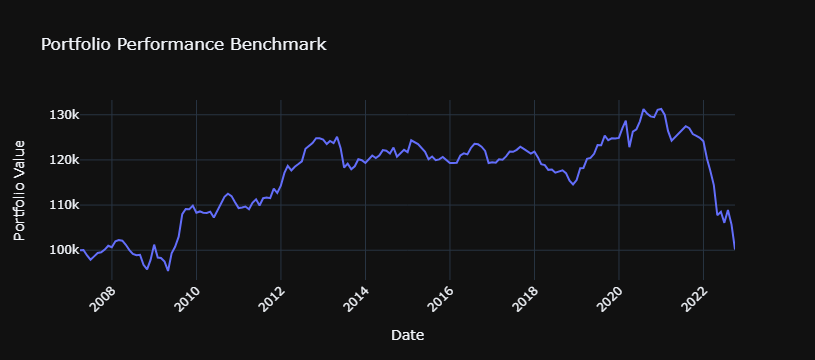

  0%|          | 0/187 [00:00<?, ?it/s]

us_ig_bonds_meet_esg/financials/util

Portfolio Metrics
Average Return (Per Annum): 0.999
Final Value: 98288.124



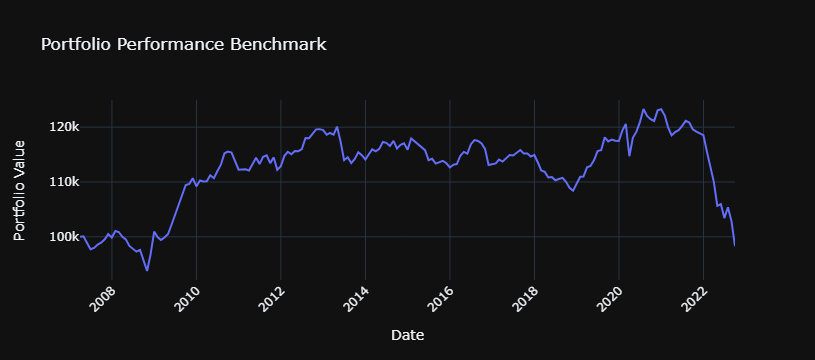

  0%|          | 0/187 [00:00<?, ?it/s]

us_ig_bonds_benchmark/financials/util

Portfolio Metrics
Average Return (Per Annum): 1.0
Final Value: 99425.318



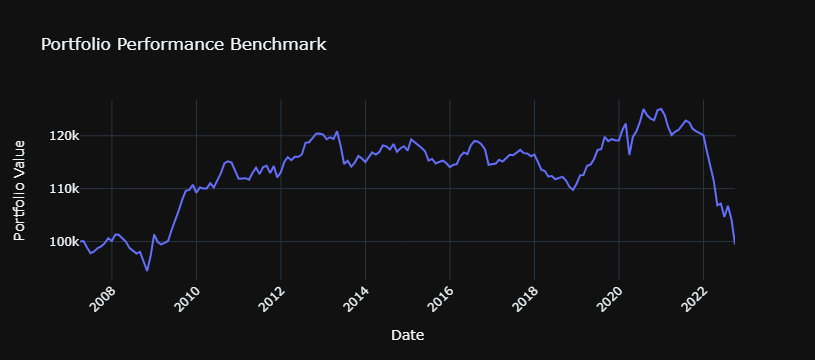

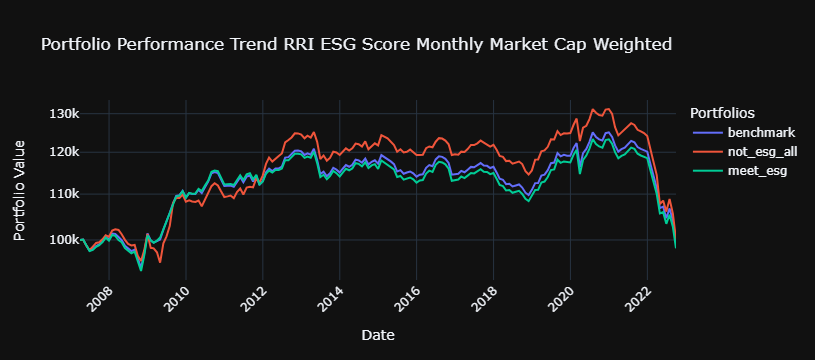

us_ig_bonds_benchmark/financials/util
Annual Return: -0.0
Max Drawdown: -0.205
Information Ratio: nan

us_ig_bonds_not_esg/financials/util
Annual Return: 0.0
Max Drawdown: -0.237
Information Ratio: 0.044

us_ig_bonds_meet_esg/financials/util
Annual Return: -0.001
Max Drawdown: -0.203
Information Ratio: -0.249



C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:74: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:85: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:92: FutureWarning:

Series.__getitem__ treating keys as positions is deprecat

  0%|          | 0/187 [00:00<?, ?it/s]

us_ig_bonds_not_esg/others

Portfolio Metrics
Average Return (Per Annum): 0.998
Final Value: 96423.507



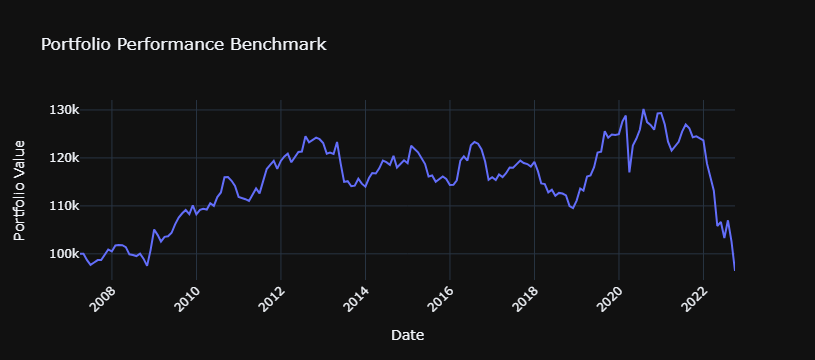

  0%|          | 0/187 [00:00<?, ?it/s]

us_ig_bonds_meet_esg/others

Portfolio Metrics
Average Return (Per Annum): 1.0
Final Value: 99293.037



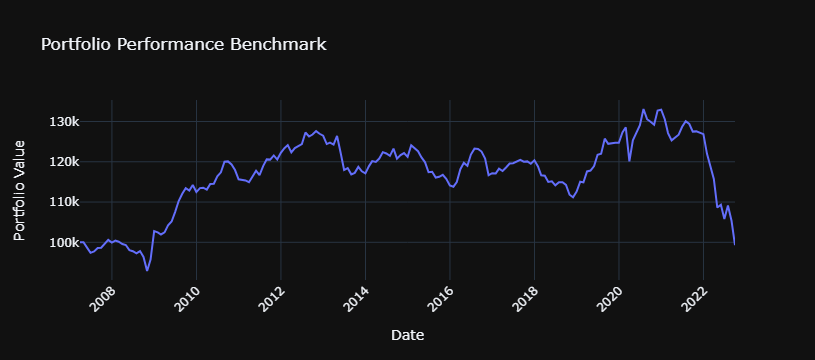

  0%|          | 0/187 [00:00<?, ?it/s]

us_ig_bonds_benchmark/others

Portfolio Metrics
Average Return (Per Annum): 1.0
Final Value: 100047.419



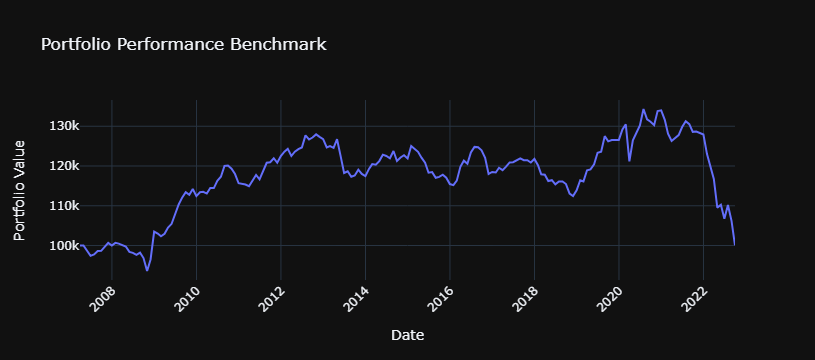

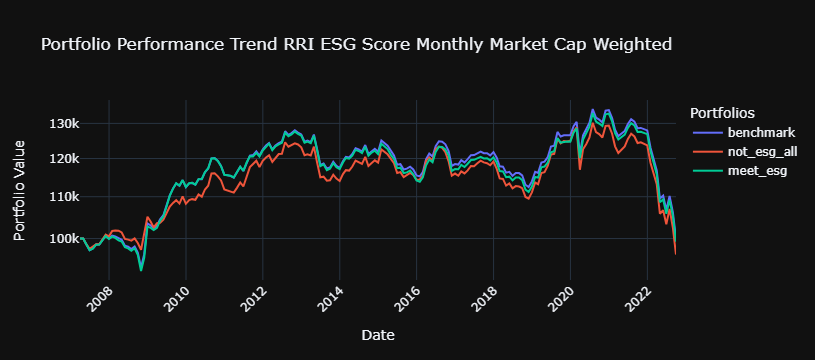

us_ig_bonds_benchmark/others
Annual Return: 0.0
Max Drawdown: -0.255
Information Ratio: nan

us_ig_bonds_not_esg/others
Annual Return: -0.002
Max Drawdown: -0.259
Information Ratio: -0.162

us_ig_bonds_meet_esg/others
Annual Return: -0.0
Max Drawdown: -0.254
Information Ratio: -0.199



In [234]:
metric  = 'trend_score'

# simulate(us_bond_dates, us_ig_df[us_ig_df[metric] > 0], us_ig_prices, 'us_ig_bonds_not_esg/ALL', bond_returns_us)
# simulate(us_bond_dates, us_ig_df[us_ig_df[metric] <= 0], us_ig_prices, 'us_ig_bonds_meet_esg/ALL', bond_returns_us)
# simulate(us_bond_dates, us_ig_df, us_ig_prices, 'us_ig_bonds_benchmark/ALL', bond_returns_us)

# analyze(us_bond_dates, bond_returns_us, f'us_ig_bonds_benchmark/ALL',  f'us_ig_bonds_not_esg/ALL', f'us_ig_bonds_meet_esg/ALL')

# financials and utilities

group = us_ig_df[us_ig_df['sector'] == 'financials/utilities']
name = 'financials/util'

simulate(us_bond_dates, group[group[metric] > 0], us_ig_prices, f'us_ig_bonds_not_esg/{name}', bond_returns_us)
simulate(us_bond_dates, group[group[metric] <= 0], us_ig_prices, f'us_ig_bonds_meet_esg/{name}', bond_returns_us)
simulate(us_bond_dates, group, us_ig_prices, f'us_ig_bonds_benchmark/{name}', bond_returns_us)

analyze(us_bond_dates, bond_returns_us, f'us_ig_bonds_benchmark/{name}',  f'us_ig_bonds_not_esg/{name}', f'us_ig_bonds_meet_esg/{name}')


# others

group = us_ig_df[us_ig_df['sector'] == 'other']
name = 'others'

simulate(us_bond_dates, group[group[metric] > 0], us_ig_prices, f'us_ig_bonds_not_esg/{name}', bond_returns_us)
simulate(us_bond_dates, group[group[metric] <= 0], us_ig_prices, f'us_ig_bonds_meet_esg/{name}', bond_returns_us)
simulate(us_bond_dates, group, us_ig_prices, f'us_ig_bonds_benchmark/{name}', bond_returns_us)

analyze(us_bond_dates, bond_returns_us, f'us_ig_bonds_benchmark/{name}',  f'us_ig_bonds_not_esg/{name}', f'us_ig_bonds_meet_esg/{name}')

  0%|          | 0/187 [00:00<?, ?it/s]

euro_ig_bonds_not_esg/financials/util

Portfolio Metrics
Average Return (Per Annum): 0.991
Final Value: 86474.691



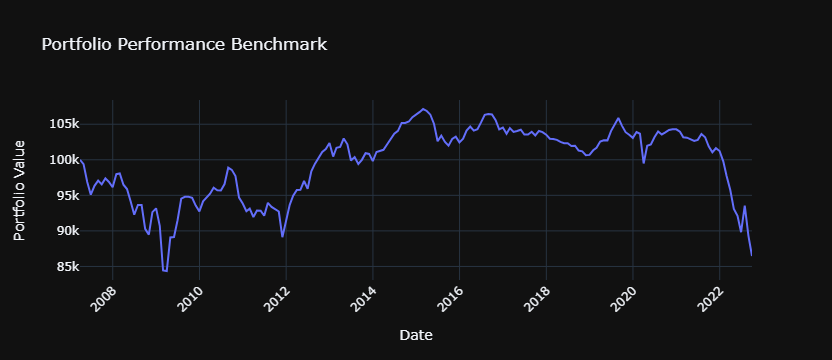

  0%|          | 0/187 [00:00<?, ?it/s]

euro_ig_bonds_meet_esg/financials/util

Portfolio Metrics
Average Return (Per Annum): 0.997
Final Value: 94770.766



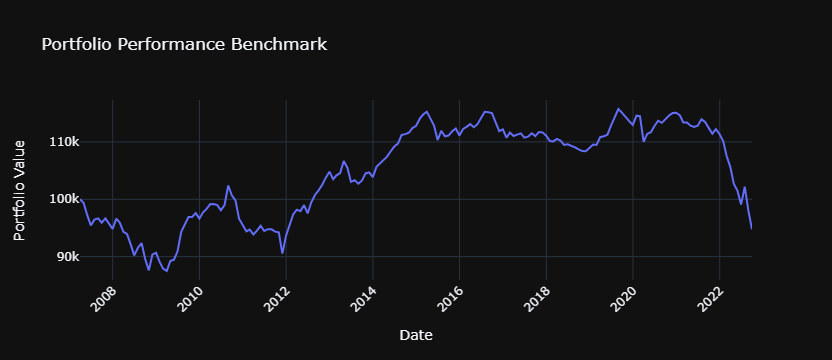

  0%|          | 0/187 [00:00<?, ?it/s]

euro_ig_bonds_benchmark/financials/util

Portfolio Metrics
Average Return (Per Annum): 0.996
Final Value: 94330.743



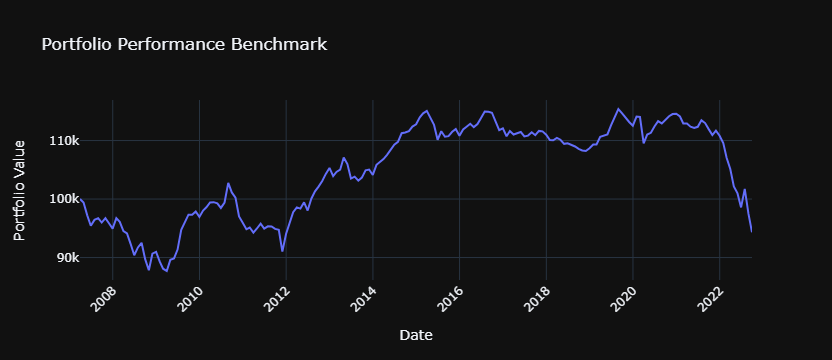

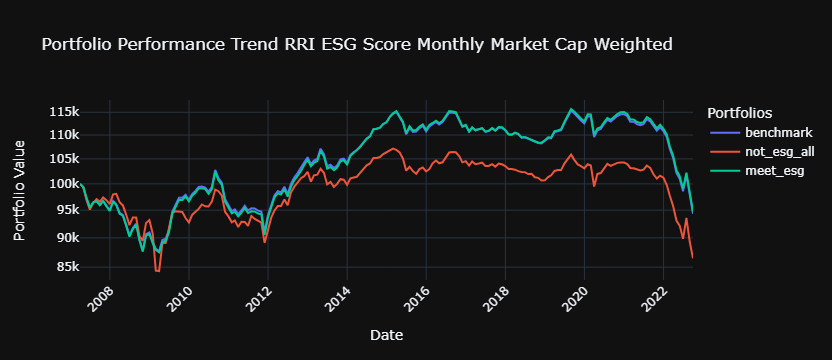

euro_ig_bonds_benchmark/financials/util
Annual Return: -0.004
Max Drawdown: -0.183
Information Ratio: nan

euro_ig_bonds_not_esg/financials/util
Annual Return: -0.009
Max Drawdown: -0.193
Information Ratio: -0.243

euro_ig_bonds_meet_esg/financials/util
Annual Return: -0.003
Max Drawdown: -0.181
Information Ratio: 0.221



C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:74: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:85: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:92: FutureWarning:

Series.__getitem__ treating keys as positions is deprecat

  0%|          | 0/187 [00:00<?, ?it/s]

euro_ig_bonds_not_esg/others

Portfolio Metrics
Average Return (Per Annum): 0.995
Final Value: 93055.806



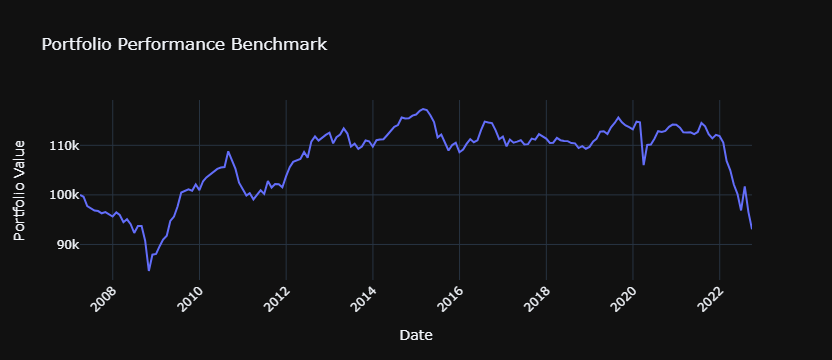

  0%|          | 0/187 [00:00<?, ?it/s]

euro_ig_bonds_meet_esg/others

Portfolio Metrics
Average Return (Per Annum): 1.0
Final Value: 100344.523



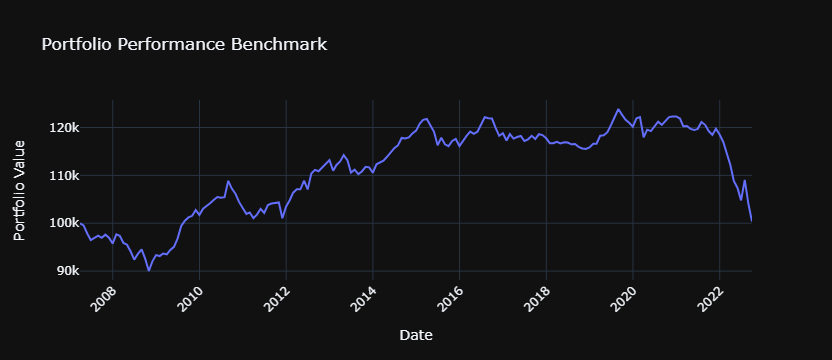

  0%|          | 0/187 [00:00<?, ?it/s]

euro_ig_bonds_benchmark/others

Portfolio Metrics
Average Return (Per Annum): 1.0
Final Value: 100183.88



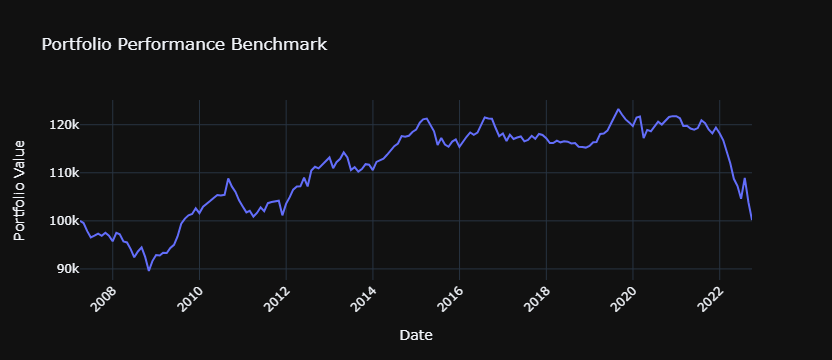

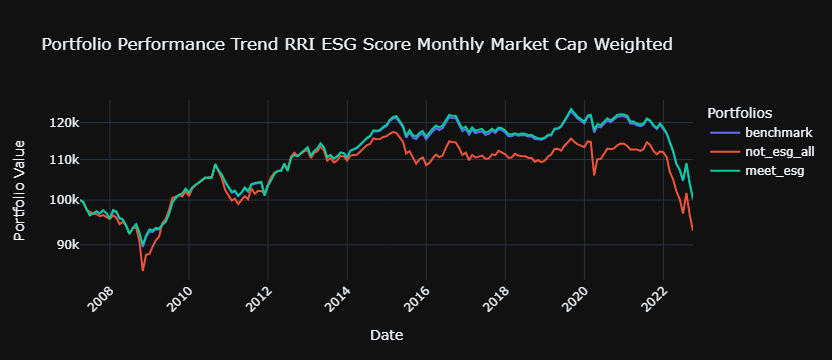

euro_ig_bonds_benchmark/others
Annual Return: 0.0
Max Drawdown: -0.187
Information Ratio: nan

euro_ig_bonds_not_esg/others
Annual Return: -0.005
Max Drawdown: -0.207
Information Ratio: -0.189

euro_ig_bonds_meet_esg/others
Annual Return: 0.0
Max Drawdown: -0.19
Information Ratio: 0.042



In [235]:
# simulate(euro_bond_dates, euro_ig_df[euro_ig_df[metric] > 0], euro_ig_prices, 'euro_ig_bonds_not_esg/ALL', bond_returns_euro)
# simulate(euro_bond_dates, euro_ig_df[euro_ig_df[metric] <= 0], euro_ig_prices, 'euro_ig_bonds_meet_esg/ALL', bond_returns_euro)
# simulate(euro_bond_dates, euro_ig_df, euro_ig_prices, 'euro_ig_bonds_benchmark/ALL', bond_returns_euro)

# analy2ze(euro_bond_dates, bond_returns_euro, f'euro_ig_bonds_benchmark/ALL',  f'euro_ig_bonds_not_esg/ALL', f'euro_ig_bonds_meet_esg/ALL')

# financials and utilities

group = euro_ig_df[euro_ig_df['sector'] == 'financials/utilities']
name = 'financials/util'

simulate(euro_bond_dates, group[group[metric] > 0], euro_ig_prices, f'euro_ig_bonds_not_esg/{name}', bond_returns_euro)
simulate(euro_bond_dates, group[group[metric] <= 0], euro_ig_prices, f'euro_ig_bonds_meet_esg/{name}', bond_returns_euro)
simulate(euro_bond_dates, group, euro_ig_prices, f'euro_ig_bonds_benchmark/{name}', bond_returns_euro)

analyze(euro_bond_dates, bond_returns_euro, f'euro_ig_bonds_benchmark/{name}',  f'euro_ig_bonds_not_esg/{name}', f'euro_ig_bonds_meet_esg/{name}')


# others

group = euro_ig_df[euro_ig_df['sector'] == 'other']
name = 'others'

simulate(euro_bond_dates, group[group[metric] > 0], euro_ig_prices, f'euro_ig_bonds_not_esg/{name}', bond_returns_euro)
simulate(euro_bond_dates, group[group[metric] <= 0], euro_ig_prices, f'euro_ig_bonds_meet_esg/{name}', bond_returns_euro)
simulate(euro_bond_dates, group, euro_ig_prices, f'euro_ig_bonds_benchmark/{name}', bond_returns_euro)

analyze(euro_bond_dates, bond_returns_euro, f'euro_ig_bonds_benchmark/{name}',  f'euro_ig_bonds_not_esg/{name}', f'euro_ig_bonds_meet_esg/{name}')

## 60/40 Returns

Simulation for US and EURO 60/40 Portfolios. 60% allocation is equitie (S&P 500 / Eurostoxx 600) and 40% are respective investment grade bonds

In [236]:
returns_60_40_spx = {}
returns_60_40_euro = {}

In [247]:
portfolio_returns_spx.keys()

dict_keys(['benchmark/financials/util/above', 'not_esg/financials/util/above', 'meet_esg/financials/util/above', 'benchmark/financials/util/below', 'not_esg/financials/util/below', 'meet_esg/financials/util/below', 'benchmark/others/above', 'not_esg/others/above', 'meet_esg/others/above', 'benchmark/others/below', 'not_esg/others/below', 'meet_esg/others/below'])

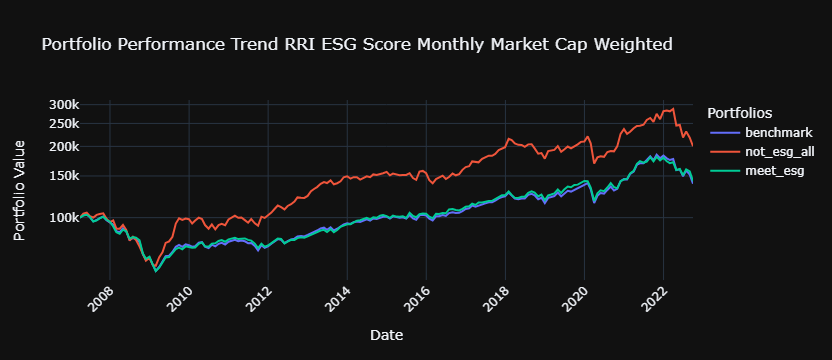

benchmark/financials/util/above
Annual Return: 0.021
Max Drawdown: -0.423
Information Ratio: nan

not_esg/financials/util/above
Annual Return: 0.046
Max Drawdown: -0.403
Information Ratio: 0.409

meet_esg/financials/util/above
Annual Return: 0.023
Max Drawdown: -0.421
Information Ratio: 0.061



C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:74: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:85: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:92: FutureWarning:

Series.__getitem__ treating keys as positions is deprecat

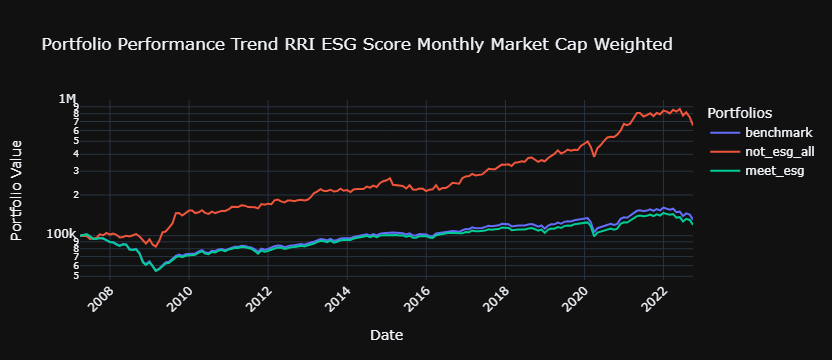

benchmark/financials/util/below
Annual Return: 0.018
Max Drawdown: -0.458
Information Ratio: nan

not_esg/financials/util/below
Annual Return: 0.129
Max Drawdown: -0.247
Information Ratio: 1.036

meet_esg/financials/util/below
Annual Return: 0.012
Max Drawdown: -0.464
Information Ratio: -0.667



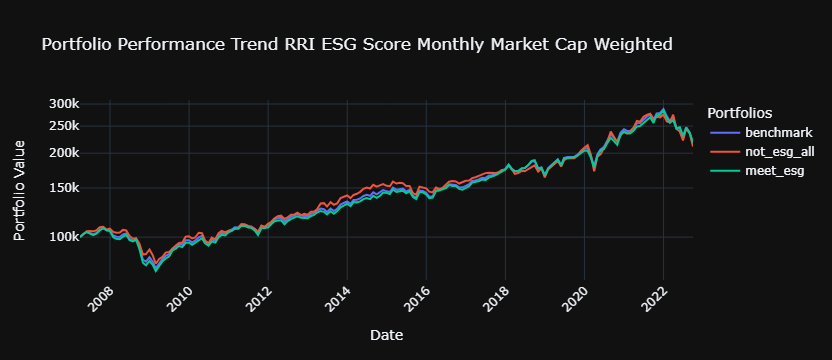

benchmark/others/above
Annual Return: 0.051
Max Drawdown: -0.283
Information Ratio: nan

not_esg/others/above
Annual Return: 0.049
Max Drawdown: -0.262
Information Ratio: -0.011

meet_esg/others/above
Annual Return: 0.052
Max Drawdown: -0.297
Information Ratio: 0.027



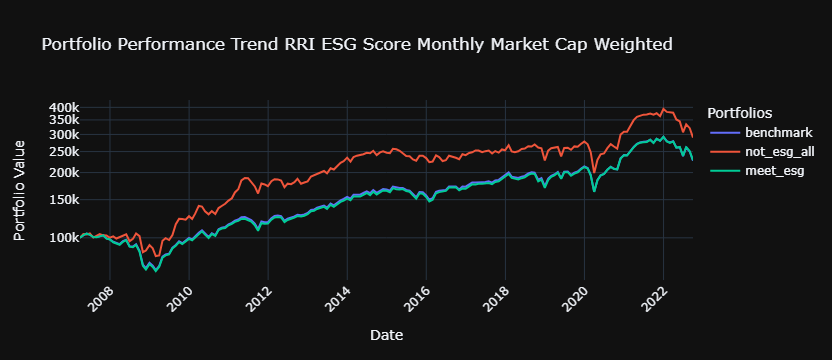

benchmark/others/below
Annual Return: 0.054
Max Drawdown: -0.321
Information Ratio: nan

not_esg/others/below
Annual Return: 0.071
Max Drawdown: -0.284
Information Ratio: 0.295

meet_esg/others/below
Annual Return: 0.055
Max Drawdown: -0.327
Information Ratio: 0.047



In [248]:
for name in portfolio_returns_spx:
    names = name.split('/')
    sect = names[1]
    if len(names) == 4:
        sect = names[1] + '/' + names[2]
    bond_returns = bond_returns_us[f'us_ig_bonds_{names[0]}/{sect}']
    returns_60_40_spx[f'{name}'] = []
    value = 0
    for i in range(len(bond_returns)):
        value = bond_returns[i] * 0.4 + portfolio_returns_spx[name][i] * 0.6
        returns_60_40_spx[f'{name}'].append(value)


# analyze(monthly_dates_spx, returns_60_40_spx, 'benchmark/ALL',  'not_esg/ALL', 'meet_esg/ALL')
analyze(monthly_dates_spx, returns_60_40_spx, 'benchmark/financials/util/above',  'not_esg/financials/util/above', 'meet_esg/financials/util/above')
analyze(monthly_dates_spx, returns_60_40_spx, 'benchmark/financials/util/below',  'not_esg/financials/util/below', 'meet_esg/financials/util/below')
analyze(monthly_dates_spx, returns_60_40_spx, 'benchmark/others/above',  'not_esg/others/above', 'meet_esg/others/above')
analyze(monthly_dates_spx, returns_60_40_spx, 'benchmark/others/below',  'not_esg/others/below', 'meet_esg/others/below')

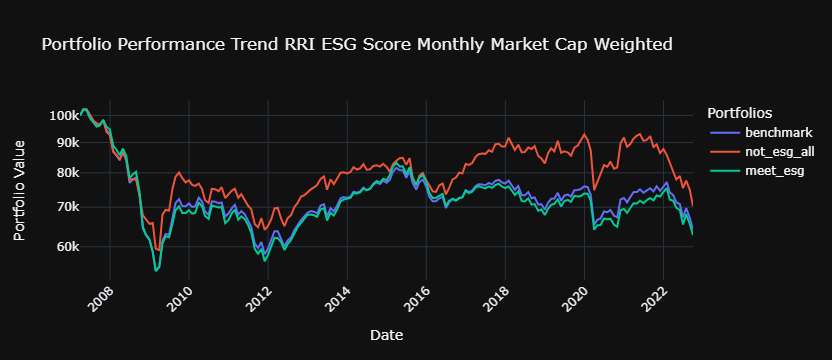

benchmark/financials/util/above
Annual Return: -0.028
Max Drawdown: -0.467
Information Ratio: nan

not_esg/financials/util/above
Annual Return: -0.023
Max Drawdown: -0.421
Information Ratio: 0.168

meet_esg/financials/util/above
Annual Return: -0.03
Max Drawdown: -0.467
Information Ratio: -0.114



C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:74: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:84: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:85: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\anish\AppData\Local\Temp\ipykernel_27492\764372542.py:92: FutureWarning:

Series.__getitem__ treating keys as positions is deprecat

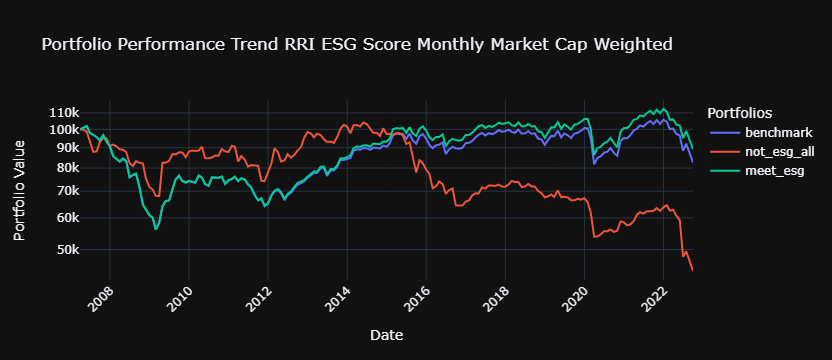

benchmark/financials/util/below
Annual Return: -0.012
Max Drawdown: -0.449
Information Ratio: nan

not_esg/financials/util/below
Annual Return: -0.051
Max Drawdown: -0.576
Information Ratio: -0.375

meet_esg/financials/util/below
Annual Return: -0.007
Max Drawdown: -0.449
Information Ratio: 0.717



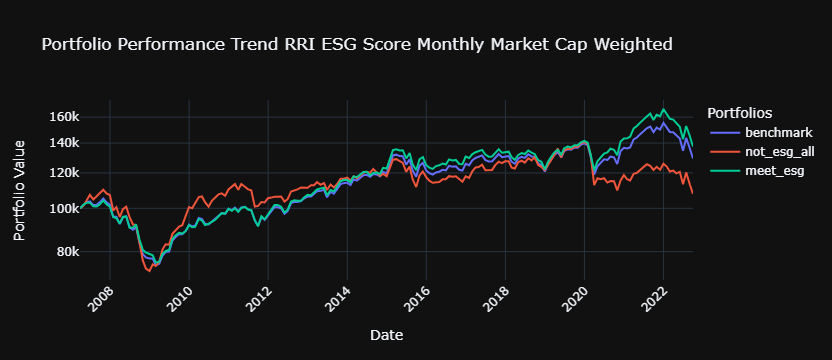

benchmark/others/above
Annual Return: 0.017
Max Drawdown: -0.291
Information Ratio: nan

not_esg/others/above
Annual Return: 0.005
Max Drawdown: -0.342
Information Ratio: -0.253

meet_esg/others/above
Annual Return: 0.021
Max Drawdown: -0.274
Information Ratio: 0.36



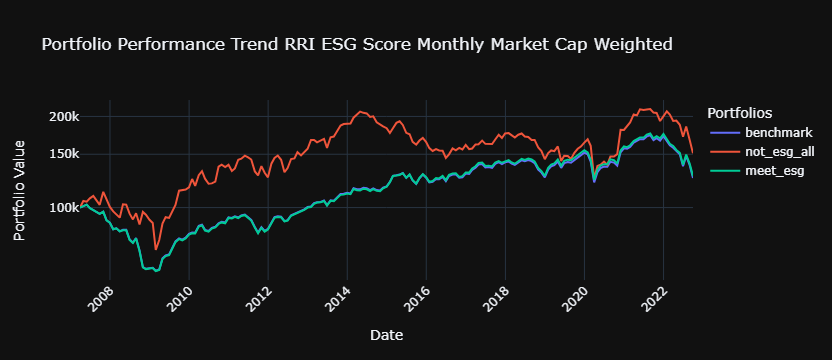

benchmark/others/below
Annual Return: 0.015
Max Drawdown: -0.395
Information Ratio: nan

not_esg/others/below
Annual Return: 0.027
Max Drawdown: -0.4
Information Ratio: 0.172

meet_esg/others/below
Annual Return: 0.015
Max Drawdown: -0.396
Information Ratio: 0.217



In [250]:
for name in portfolio_returns_euro:
    names = name.split('/')
    sect = names[1]
    if len(names) == 4:
        sect = names[1] + '/' + names[2]
    bond_returns = bond_returns_euro[f'euro_ig_bonds_{names[0]}/{sect}']
    returns_60_40_euro[f'{name}'] = []
    value = 0
    for i in range(len(bond_returns)):
        value = bond_returns[i] * 0.4 + portfolio_returns_euro[name][i] * 0.6
        returns_60_40_euro[f'{name}'].append(value)


# analyze(monthly_dates_euro, returns_60_40_euro, 'benchmark/ALL',  'not_esg/ALL', 'meet_esg/ALL')
analyze(monthly_dates_euro, returns_60_40_euro, 'benchmark/financials/util/above',  'not_esg/financials/util/above', 'meet_esg/financials/util/above')
analyze(monthly_dates_euro, returns_60_40_euro, 'benchmark/financials/util/below',  'not_esg/financials/util/below', 'meet_esg/financials/util/below')
analyze(monthly_dates_euro, returns_60_40_euro, 'benchmark/others/above',  'not_esg/others/above', 'meet_esg/others/above')
analyze(monthly_dates_euro, returns_60_40_euro, 'benchmark/others/below',  'not_esg/others/below', 'meet_esg/others/below')